## Prompt and actions on Questions


* Look at `registrants` Table in postgres
* Consider home address as the location to start query from multiple locations.
* Secondly, search for locations in question from `prospective_business_description` column.

In [121]:
import arcgis
from arcgis.gis import GIS
from arcgis.geoenrichment import *
from arcgis.features import FeatureLayer, FeatureLayerCollection, GeoAccessor
from arcgis.geocoding import geocode
import pandas as pd
import sys
sys.path.append('../../')
from utils import get_config

### Check if the user belongs to a Food desert

#### Check meal_gap or CalFresh data to check Food insecurity rate for some radius of area
* Map the meal gap data is at County level, not sure if it is really helpful for us.
* CalFresh Data might need to be standardized, but it is on zip level.

##### Can we query a geography within a certain radius of a location.

##### Can we get list of block groups given a region. For now we will consider planned community areas.

In [96]:
## Get the relevant block groups
region_of_interest = 'RANCHO PENASQUITOS'
region_of_interest = region_of_interest.lower()
cpa_bg_map = pd.read_csv("../resources/san_diego_county_cpa_blk_grp_map.csv", dtype ='str')
mask = cpa_bg_map['CPANAME']==region_of_interest
block_groups_in_region = cpa_bg_map[mask]
block_groups_in_region_list = block_groups_in_region['fips'].tolist()

In [97]:
block_groups_in_region_list[:10]

['060730083361',
 '060730083362',
 '060730083371',
 '060730083372',
 '060730083373',
 '060730083651',
 '060730083652',
 '060730083661',
 '060730083662',
 '060730083663']

#### Option 1

In [98]:
# Query the block group for respective variables and feature layer.
variables = "demographics"
if variables=="demographics":
    url = "https://services1.arcgis.com/eGSDp8lpKe5izqVc/arcgis/rest/services/aff1b6/FeatureServer/0"
ft_lyr = FeatureLayer(gis=gis,
                       url=url)
out_fields = ["fips", "occeduc_cy","pif60_cy","OCCFOOD_CY"]  

In [145]:
where = "fips IN (" + ",".join(block_groups_in_region_list) + ")"
#print(where)
result_rows = ft_lyr.query(
    where=where,
    out_fields=out_fields,
    return_geometry=True,
    as_df=True,
)
result_rows.head(2)

,FID,fips,occeduc_cy,pif60_cy,occfood_cy,SHAPE
0,508,060730170181,41.0,2.0,82.0,"{""rings"": [[[-13035625.351, 3890389.58830002],..."
1,509,060730170182,28.0,0.0,77.0,"{""rings"": [[[-13035887.7309999, 3888939.776800..."


In [155]:
map_centre = region_of_interest+", San Diego County"
print(f"Map Centre: {map_centre}")
m1 = gis.map(map_centre, zoomlevel=12)
result_rows.spatial.plot(renderer_type='c',
#                          method='esriClassifyNaturalBreaks',
#                          class_count=10,  # choose the number of classes
#                          col='occeduc_cy',
#                          cmap='hot',  # color map to pick colors from for each class
#                          alpha=0.7 ,
                          
                         map_widget= m1,)
m1

Map Centre: rancho penasquitos, San Diego County


MapView(layout=Layout(height='400px', width='100%'))

#### Option 2

In [136]:
registrant_address = "11010 Caminito Alvarez, San Diego, 92126"
matched_registrant_address = geocode(address=registrant_address,
                 max_locations = 1
                )
# matched_registrant_address

In [151]:
matched_registrant_address

[{'address': '11010 Caminito Alvarez, San Diego, California, 92126',
  'location': {'x': -117.1675950182451, 'y': 32.90706625343636},
  'score': 100,
  'attributes': {'Loc_name': 'World',
   'Status': 'M',
   'Score': 100,
   'Match_addr': '11010 Caminito Alvarez, San Diego, California, 92126',
   'LongLabel': '11010 Caminito Alvarez, San Diego, CA, 92126, USA',
   'ShortLabel': '11010 Caminito Alvarez',
   'Addr_type': 'PointAddress',
   'Type': '',
   'PlaceName': '',
   'Place_addr': '11010 Caminito Alvarez, San Diego, California, 92126',
   'Phone': '',
   'URL': '',
   'Rank': 20,
   'AddBldg': '',
   'AddNum': '11010',
   'AddNumFrom': '',
   'AddNumTo': '',
   'AddRange': '',
   'Side': '',
   'StPreDir': '',
   'StPreType': 'Caminito',
   'StName': 'Alvarez',
   'StType': '',
   'StDir': '',
   'BldgType': '',
   'BldgName': '',
   'LevelType': '',
   'LevelName': '',
   'UnitType': '',
   'UnitName': '',
   'SubAddr': '',
   'StAddr': '11010 Caminito Alvarez',
   'Block': '',


In [135]:
lat_long = [matched_registrant_address[0]['location']['x'],matched_registrant_address[0]['location']['y']]
address_score = matched_registrant_address[0]['score']
address_identified = matched_registrant_address[0]['address']
print(f"Important Fields: \n Address Matched: {address_identified} \n Latitude,Longitude: {lat_long}\n Match SCore: {address_score}")

Important Fields: 
 Address Matched: 11010 Caminito Alvarez, San Diego, California, 92126 
 Latitude,Longitude: [-117.1675950182451, 32.90706625343636]
 Match SCore: 100


In [150]:
point_geometry = matched_registrant_address[0]['location']
point_geometry
from arcgis.geometry import Point
point = Point(point_geometry['x'], point_geometry['y'], point_geometry['spatialReference'])
point

KeyError: 'spatialReference'

In [149]:
result_rows_2 = ft_lyr.query(
    where=where,
    #out_fields=out_fields,
    return_geometry=True,
    as_df=True,
    geometry=-117,32,
    geometryType='esriGeometryPoint',
    spatialRel='esriSpatialRelTouches'
)
result_rows_2.head(2)

,FID,fips,blkf20_cy,mage69_fy,whtm5_cy,pif60_cy,asn10_fy,occeduc_cy,oldrgenscy,medoage_cy,...,male55_fy,mage16_fy,age71_fy,medmmagefy,hagebasefy,othf35_fy,a65i0_cy,Shape__Area,Shape__Length,SHAPE


In [112]:
from arcgis.mapping import symbol

colormaps = symbol.ALLOWED_CMAPS
for a,b,c,d,e in zip(colormaps[::5], colormaps[1::5], colormaps[2::5], colormaps[3::5], colormaps[4::5]):
    print("{:<20}{:<20}{:<20}{:<20}{:<}".format(a,b,c,d,e))

Accent              Accent_r            Blues               Blues_r             BrBG
BrBG_r              BuGn                BuGn_r              BuPu                BuPu_r
CMRmap              CMRmap_r            Dark2               Dark2_r             GnBu
GnBu_r              Greens              Greens_r            Greys               Greys_r
OrRd                OrRd_r              Oranges             Oranges_r           PRGn
PRGn_r              Paired              Paired_r            Pastel1             Pastel1_r
Pastel2             Pastel2_r           PiYG                PiYG_r              PuBu
PuBuGn              PuBuGn_r            PuBu_r              PuOr                PuOr_r
PuRd                PuRd_r              Purples             Purples_r           RdBu
RdBu_r              RdGy                RdGy_r              RdPu                RdPu_r
RdYlBu              RdYlBu_r            RdYlGn              RdYlGn_r            Reds
Reds_r              Set1                Set1_r     

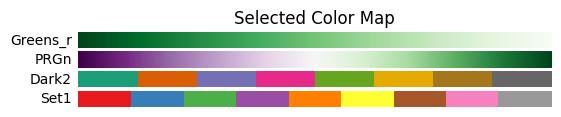

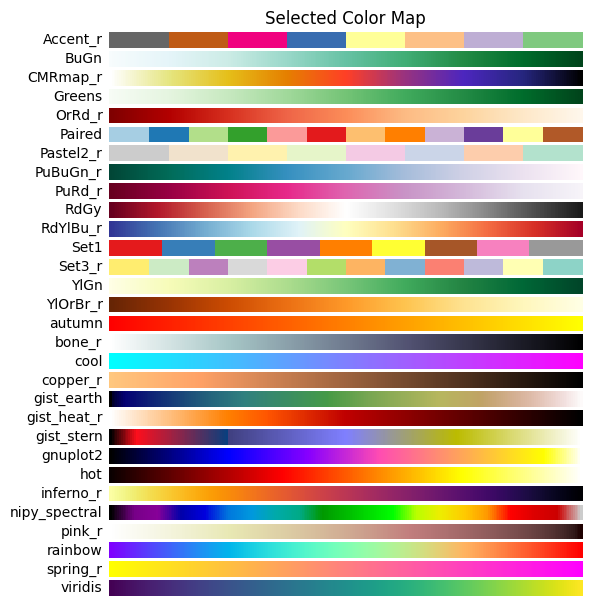

In [116]:
from arcgis.mapping import display_colormaps
display_colormaps(['Greens_r', 'PRGn', 'Dark2', 'Set1'])
display_colormaps(colormaps[1::5])

#### Check Food Swamp: Desnsity of fast food and Convenience Store

#### Does this have Highly Palatable Food.

#### e.g. Mexican Food business in Chula Vista and business type as Food Truck. (Business type data to be picked up from where? )

In [3]:
username = get_config("arcgis","username")
password = get_config("arcgis","passkey")

In [2]:
gis = GIS("https://ucsdonline.maps.arcgis.com/home", username=username, password=password)

#### Render a map

In [6]:
m1 = gis.map("United States", zoomlevel=4)
m1

MapView(layout=Layout(height='400px', width='100%'))

In [10]:
# Let's use a sample feature layer available with us on US map. 
# Lets take farmers market which we can plot using symbol on basis of zip 
fl = FeatureLayer(gis=gis,
            url="https://services1.arcgis.com/eGSDp8lpKe5izqVc/arcgis/rest/services/a09656/FeatureServer/0")

df = GeoAccessor.from_layer(fl)
df

,FID,name,address,longitude,latitude,SHAPE
0,1,Colorado Farm and Art Market,"7350 Pine Creek Road, Colorado Springs, Colora...",-104.813284,38.937974,"{""x"": -11667761.399188498, ""y"": 4712790.752459..."
1,2,Market in The Park,"300 Conti, Mobile, Alabama 36602",-88.044585,30.690215,"{""x"": -9801078.355560867, ""y"": 3592582.7091098..."
2,3,The Territory Farmers' Market,"2000 Territory Drive, Galena, Illinois 61036",-90.317574,42.399287,"{""x"": -10054106.340682408, ""y"": 5220979.678882..."
3,4,City of Plymouth Farmers Market,"15500 County Road 6, Plymouth, Minnesota 55447",-93.47626,44.99638,"{""x"": -10405729.674340973, ""y"": 5620951.682596..."
4,5,Durham Farmers' Market,"501 Foster Street, Durham, North Carolina 27701",-78.901498,36.000645,"{""x"": -8783274.560550418, ""y"": 4300710.0709383..."
...,...,...,...,...,...,...
1051,1052,Bexley Farmers Market,"South Dawson Avenue & East Main Street, Bexley...",-82.93572,39.95714,"{""x"": -9232362.116269127, ""y"": 4859715.9343609..."
1052,1053,2nd Street Market,"600 East 2nd Street, Dayton, OH, USA",-84.180817,39.762778,"{""x"": -9370965.65404552, ""y"": 4831529.48735039..."
1053,1054,Farmers Market Centerville Texas,"114 E St Marys St, Centerville, TX, USA",-95.978552,31.258045,"{""x"": -10684283.583522432, ""y"": 3666306.799085..."
1054,1055,Downtown Beloit Farmers' Market - Winter,"557 E Grand Ave, Beloit, WI, USA",-89.031517,42.499645,"{""x"": -9910943.143985387, ""y"": 5236120.2130659..."


In [11]:
df.spatial.plot(map_widget= m1)

True